# Machine Learning for metabolomes of microbial communities

In [1]:
# imports
import sys
sys.path.append( '..' )

from helpers import *
from FIA import *
from ML4com import *
from DL4com import *
from VAE.vae import *

## Loading in

In [2]:
orig_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/data/Com8_grown_together"))
data_dir  = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/FIA/Com8_grown_together"))
run_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/ML/latent/hp_optimization"))

verbosity = 1
backend_name = "tensorflow"
computation = "cpu"
name = "cos_fin" # "tied_fin"
project = f"vae_{backend_name}_{computation}_{name}"
outdir = Path( os.path.normpath( os.path.join(run_dir, project)) )
if not os.path.isdir(outdir):
    os.mkdir(outdir)


strains = pd.read_csv( os.path.join(orig_dir, "strains.tsv"), sep="\t")
comm = pd.read_csv( os.path.join(orig_dir, "comb_one_hot.tsv"), sep="\t")
metData = pd.read_csv( os.path.join(orig_dir, "metData.tsv"), sep="\t")
metData.index = pd.read_csv( os.path.join(orig_dir, "metName.tsv"), sep="\t")

latent_space = pd.read_csv("/mnt/d/runs/VAE/results/encoded_mu_tied_cos.tsv", index_col=["Unnamed: 0"], sep="\t")


## Normalization

In [3]:
ys = comm
targets = strains.values.flatten()

## Learning and tuning

In [4]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

## Saving training

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=sklearn.exceptions.UndefinedMetricWarning)

### Decision Tree

In [6]:
from sklearn.tree import DecisionTreeClassifier

configuration_space = ConfigurationSpace()
ccp_alpha   = Float("ccp_alpha", (1e-3, 1e0), log=True, default=0.01)
configuration_space.add_hyperparameters([ccp_alpha])

classifier = SKL_Classifier(latent_space, ys, cv=5, configuration_space=configuration_space, classifier=DecisionTreeClassifier)

scenario = Scenario( classifier.configuration_space, deterministic=True, 
                     n_workers=1, n_trials=200,
                     walltime_limit=np.inf, cputime_limit=np.inf, trial_memory_limit=None,
                     output_directory=outdir)

facade = HyperparameterOptimizationFacade(scenario, classifier.train, overwrite=True, logging_level=30-verbosity*10)

mlflow.set_tracking_uri(Path(os.path.join(outdir, "mlruns")))
mlflow.set_experiment(f"{name}_decision_tree")
# mlflow.autolog(log_datasets=False, log_models=False, log_model_signatures=False, silent=verbosity<=2)
with mlflow.start_run(run_name=project):
    mlflow.set_tag("test_identifier", "parent")
    incumbent = facade.optimize()

[INFO][abstract_initial_design.py:147] Using 10 initial design configurations and 0 additional configurations.


2024/05/03 15:46:16 INFO mlflow.tracking.fluent: Experiment with name 'cos_fin_decision_tree' does not exist. Creating a new experiment.


[INFO][abstract_intensifier.py:305] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:515] Added config 8f03e1 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:590] Added config 7709f8 and rejected config 8f03e1 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:319] Finished 50 trials.
[INFO][smbo.py:319] Finished 100 trials.
[INFO][smbo.py:319] Finished 150 trials.
[INFO][smbo.py:319] Finished 200 trials.
[INFO][smbo.py:327] Configuration budget is exhausted:
[INFO][smbo.py:328] --- Remaining wallclock time: inf
[INFO][smbo.py:329] --- Remaining cpu time: inf
[INFO][smbo.py:330] --- Remaining trials: 0


In [9]:
if isinstance(incumbent, list):
    best_hp = incumbent[0]
else: 
    best_hp = incumbent

metrics_df = cross_validate_model_sklearn(DecisionTreeClassifier, latent_space, ys, targets, config=best_hp,
								          fold=StratifiedKFold(n_splits=5), verbosity=0)

  0%|          | 0/8 [00:00<?, ?it/s]


KeyError: 0

## Random Forest

### Standard

In [10]:
from sklearn.ensemble import RandomForestClassifier

configuration_space = ConfigurationSpace()
ccp_alpha       = Float("ccp_alpha", (1e-3, 1e-1), log=True, default=0.01)
n_estimators    = Integer("n_estimators", (10,1000), log=True, default=100)
max_depth       = Integer("max_depth", (5, 100), default=20)
configuration_space.add_hyperparameters([ccp_alpha, n_estimators, max_depth])

classifier = SKL_Classifier(latent_space, ys, cv=5, configuration_space=configuration_space, classifier=RandomForestClassifier)

scenario = Scenario( classifier.configuration_space, deterministic=True, 
                     n_workers=1, n_trials=200,
                     walltime_limit=np.inf, cputime_limit=np.inf, trial_memory_limit=None,
                     output_directory=outdir)

facade = HyperparameterOptimizationFacade(scenario, classifier.train, overwrite=True, logging_level=30-verbosity*10)

mlflow.set_tracking_uri(Path(os.path.join(outdir, "mlruns")))
mlflow.set_experiment(f"{name}_random_forest")
# mlflow.autolog(log_datasets=False, log_models=False, log_model_signatures=False, silent=verbosity<=2)
with mlflow.start_run(run_name=project):
    mlflow.set_tag("test_identifier", "parent")
    incumbent = facade.optimize()

[INFO][abstract_initial_design.py:147] Using 30 initial design configurations and 0 additional configurations.


2024/05/03 15:51:14 INFO mlflow.tracking.fluent: Experiment with name 'cos_fin_random_forest' does not exist. Creating a new experiment.


[INFO][abstract_intensifier.py:305] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:515] Added config fe7927 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:590] Added config 25502f and rejected config fe7927 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:590] Added config 52024e and rejected config 25502f as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:590] Added config 03a6c7 and rejected config 52024e as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:590] Added config 1b5f2c and rejected config 03a6c7 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:319] Finished 50 trials.
[INFO][abstract_intensifier.py:590] Added config 0b4cd4 and rejected config 1b5f2c as incumbent because it is not better than the incumben

In [12]:
if isinstance(incumbent, list):
    best_hp = incumbent[0]
else: 
    best_hp = incumbent

metrics_df = cross_validate_model_sklearn(RandomForestClassifier, latent_space, ys, targets, config=best_hp,
								          fold=StratifiedKFold(n_splits=5), verbosity=0)

100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


### Gradient Boosting

##### Extreme Gradiant Boosting

In [15]:
from xgboost import XGBClassifier

configuration_space = ConfigurationSpace()
objective           = Constant( "objective",            "binary:logistic")
num_parallel_tree   = Constant( "num_parallel_tree",    4)
n_estimators        = Integer(  "n_estimators",         (10,1000), log=True, default=100)
max_depth           = Integer(  "max_depth",            (1, 100), default=20)
subsample           = Float(    "subsample",            (1e-1, 1e0), default=1e0)
learning_rate       = Float(    "learning_rate",        (1e-2, 5e-1), default=1e-1)
configuration_space.add_hyperparameters([objective, num_parallel_tree, n_estimators, max_depth, subsample, learning_rate])

classifier = SKL_Classifier( latent_space, ys, cv=5, configuration_space=configuration_space, classifier=XGBClassifier )

scenario = Scenario( classifier.configuration_space, deterministic=True, n_workers=1, n_trials=200,
                     walltime_limit=np.inf, cputime_limit=np.inf, trial_memory_limit=None,
                     output_directory=outdir)

facade = HyperparameterOptimizationFacade(scenario, classifier.train, overwrite=True, logging_level=30-verbosity*10)

mlflow.set_tracking_uri(Path(os.path.join(outdir, "mlruns")))
mlflow.set_experiment(f"{name}_xgboost")
# mlflow.autolog(log_datasets=False, log_models=False, log_model_signatures=False, silent=verbosity<=2)
with mlflow.start_run(run_name=project):
    mlflow.set_tag("test_identifier", "parent")
    incumbent = facade.optimize()

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 60 to 50 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 50 initial design configurations and 0 additional configurations.


2024/05/03 15:58:57 INFO mlflow.tracking.fluent: Experiment with name 'cos_fin_xgboost' does not exist. Creating a new experiment.


[INFO][abstract_intensifier.py:305] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:515] Added config 829f77 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:590] Added config 35bb85 and rejected config 829f77 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:590] Added config 347753 and rejected config 35bb85 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:590] Added config 0e6b67 and rejected config 347753 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:590] Added config f7e065 and rejected config 0e6b67 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:319] Finished 50 trials.
[INFO][abstract_intensifier.py:590] Added config 9d7cbc and rejected config f7e065 as incumbent because it is not better than the incumben

In [ ]:
if isinstance(incumbent, list):
    best_hp = incumbent[0]
else: 
    best_hp = incumbent

metrics_df = cross_validate_model_sklearn(XGBClassifier, latent_space, ys, targets, config=best_hp,
								          fold=StratifiedKFold(n_splits=5), verbosity=0)

NameError: name 'XGBClassifier' is not defined

## Analysis

In [13]:
metrics_df

,Organism,Cross-Validation run,Accuracy,AUC,TPR,FPR,Threshold,Conf_Mat
0,0,1,0.285714,0.266667,"[0.0, 0.3333333333333333, 1.0]","[0.0, 0.8, 1.0]","[inf, 1.0, 0.0]","[[1, 4], [6, 3]]"
1,0,2,0.500000,0.433333,"[0.0, 0.6666666666666666, 1.0]","[0.0, 0.8, 1.0]","[inf, 1.0, 0.0]","[[1, 4], [3, 6]]"
2,0,3,0.571429,0.533333,"[0.0, 0.6666666666666666, 1.0]","[0.0, 0.6, 1.0]","[inf, 1.0, 0.0]","[[2, 3], [3, 6]]"
3,0,4,0.538462,0.475000,"[0.0, 0.75, 1.0]","[0.0, 0.8, 1.0]","[inf, 1.0, 0.0]","[[1, 4], [2, 6]]"
4,0,5,0.461538,0.450000,"[0.0, 0.5, 1.0]","[0.0, 0.6, 1.0]","[inf, 1.0, 0.0]","[[2, 3], [4, 4]]"
5,C. ramosum,1,0.285714,0.266667,"[0.0, 0.3333333333333333, 1.0]","[0.0, 0.8, 1.0]","[inf, 1.0, 0.0]","[[1, 4], [6, 3]]"
6,C. ramosum,2,0.428571,0.377778,"[0.0, 0.5555555555555556, 1.0]","[0.0, 0.8, 1.0]","[inf, 1.0, 0.0]","[[1, 4], [4, 5]]"
7,C. ramosum,3,0.642857,0.544444,"[0.0, 0.8888888888888888, 1.0]","[0.0, 0.8, 1.0]","[inf, 1.0, 0.0]","[[1, 4], [1, 8]]"
8,C. ramosum,4,0.692308,0.637500,"[0.0, 0.875, 1.0]","[0.0, 0.6, 1.0]","[inf, 1.0, 0.0]","[[2, 3], [1, 7]]"
9,C. ramosum,5,0.538462,0.475000,"[0.0, 0.75, 1.0]","[0.0, 0.8, 1.0]","[inf, 1.0, 0.0]","[[1, 4], [2, 6]]"


### Plotting

In [ ]:
algorithm = "decision_tree"

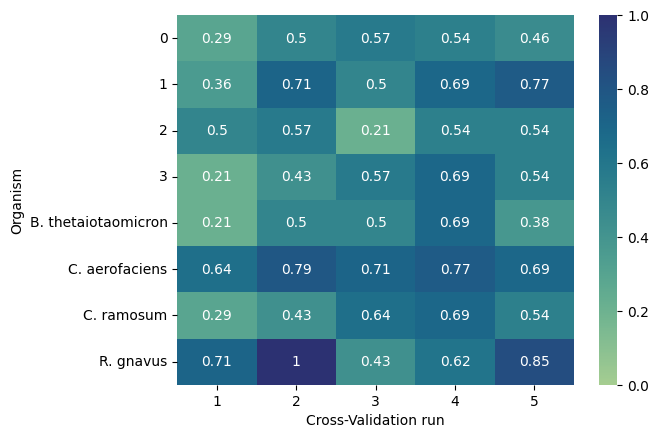

In [14]:
# Accuracy CV matrix
ax = sns.heatmap(metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Accuracy"),
                 vmin=0, vmax=1.0, annot=True, cmap=sns.color_palette("crest", as_cmap=True))
# plt.savefig(f'../../runs/ML/annot/{algorithm}/heatmap_accuracies_1.png')  
plt.show()

In [ ]:
plot_cv_confmat(ys=ys, target_labels=metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Accuracy").index,
                accuracies=np.mean(metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Accuracy").values, axis=1),
                confusion_matrices=np.sum(metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Conf_Mat").values, axis=1),
				outdir=f"../../runs/ML/annot/{algorithm}", name="class_annot_test_smac")

### DT depiction

In [ ]:
model = DecisionTreeClassifier(random_state=42)

# for i, estimator in enumerate(model.estimators_):
for i, s in enumerate(strains):
    model.fit(X.transpose(),ys.transpose()[i])
    plot_decision_trees(model=model, feature_names=X.index, class_names=["absent", s], outdir=outdir, name=f"decisiontree/tree_{s}{suffix}")

NameError: name 'DecisionTreeClassifier' is not defined

### Feature importance

In [ ]:
feature_importances = {}
for i, s in enumerate(strains["0"]):
    model = XGBClassifier(**best_hp)
    model.fit(X.values, ys[f"{i}"])
    feature_importances[s] = model.feature_importances_

    imp_feat = feature_importances.get(s) > 0.1

    plt.bar(X.columns[imp_feat], feature_importances.get(s)[imp_feat])
    plt.savefig(f"../../reports/ML/XGBoost/important_features_{s}_3_strict.png")
    plt.close()

In [ ]:
feat_imp_df = pd.DataFrame(feature_importances, index=X.columns)
feat_imp_df.to_csv("../../reports/ML/XGBoost/feature_importance_2.tsv", sep="\t")

In [ ]:
feat_imp_df["B. vulgatus"].loc[feat_imp_df["B. vulgatus"].max() == feat_imp_df["B. vulgatus"]]

metNames
Palmitoylethanolamide[M+H]+\n3-Dehydrosphinganine[M+H]+\nSphingosine[M+H]    0.719717
Name: B. vulgatus, dtype: float32

In [ ]:
strains

,0
0,C. ramosum
1,R. gnavus
2,C. aerofaciens
3,B. thetaiotaomicron
4,B. uniformis
5,B. vulgatus
6,F. nucleatum
7,R. intestinalis
